### Import

In [90]:
import pandas as pd
import talib 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [91]:
df = pd.read_csv("./data/stocks/INTL.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-03-06,2.253944,2.253944,2.253944,2.253944,2.253944,1300
1995-03-07,1.878287,2.066116,1.878287,1.878287,1.878287,5800
1995-03-08,1.878287,1.878287,1.878287,1.878287,1.878287,0
1995-03-09,1.878287,1.878287,1.878287,1.878287,1.878287,0
1995-03-10,1.878287,1.878287,1.878287,1.878287,1.878287,0


### TA indicators

In [105]:
df['SMA_10'] = talib.SMA(df['Close'], timeperiod=10)
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
df["Upper_BB"], df["Middle_BB"], df["Lower_BB"] = talib.BBANDS(df["Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)
df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_20,EMA_20,RSI_14,Upper_BB,Middle_BB,Lower_BB,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,,,,,,,
1995-03-06,2.253944,2.253944,2.253944,2.253944,2.253944,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-07,1.878287,2.066116,1.878287,1.878287,1.878287,5800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-08,1.878287,1.878287,1.878287,1.878287,1.878287,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-09,1.878287,1.878287,1.878287,1.878287,1.878287,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-10,1.878287,1.878287,1.878287,1.878287,1.878287,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df.fillna(method='ffill', inplace=True)  
#df.dropna(inplace=True)
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

if np.any(np.isnan(scaled_data)):
    print("Dữ liệu sau khi chuẩn hóa chứa NaN. Điền bằng 0.")
    scaled_data = np.nan_to_num(scaled_data, nan=0.0)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 90
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

C:\Users\Admin\AppData\Local\Temp\ipykernel_22384\1522001070.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [94]:
model = Sequential([
    LSTM(64, return_sequences=False),
    #Dense(64, activation="relu"),
    #LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='mse',
             metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [95]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stop])

Epoch 1/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0211 - mae: 0.0920 - val_loss: 5.3097e-04 - val_mae: 0.0184
Epoch 2/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012 - mae: 0.0217 - val_loss: 2.9410e-04 - val_mae: 0.0127
Epoch 3/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.2934e-04 - mae: 0.0170 - val_loss: 3.8360e-04 - val_mae: 0.0155
Epoch 4/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.0197e-04 - mae: 0.0156 - val_loss: 3.4215e-04 - val_mae: 0.0145
Epoch 5/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.7321e-04 - mae: 0.0151 - val_loss: 5.9932e-04 - val_mae: 0.0212
Epoch 6/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.9757e-04 - mae: 0.0135 - val_loss: 6.7332e-04 - val_mae: 0.0230
Epoch 7/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.8733e-04 - mae: 0.0143 - val_loss: 2.0206e-04 - val_mae: 0.0106
Epoch 8/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.1235e-04 - mae: 0.0139 - val_loss: 3.9199e-04 - 

In [96]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

if np.any(np.isnan(predictions)) or np.any(np.isnan(y_test_actual)):
    #print("Dự đoán hoặc giá thực tế chứa NaN. Điền bằng 0.")
    predictions = np.nan_to_num(predictions, nan=0.0)
    y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'RMSE: {rmse}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 1.6185941981163157


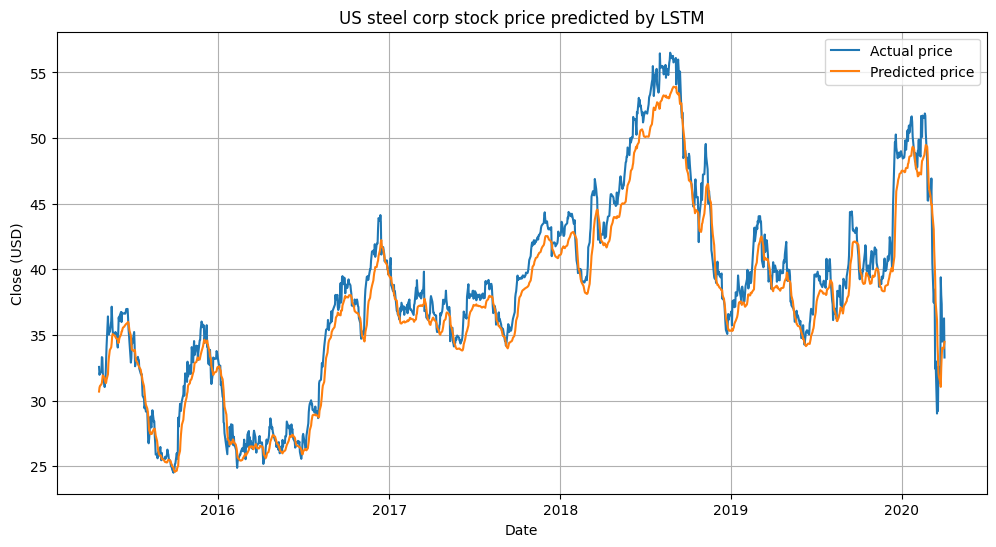

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted price')
plt.title('US steel corp stock price predicted by LSTM')
plt.xlabel('Date')
plt.ylabel('Close (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
def process_stock(ticker, data_path="./data/stocks/{}.csv"):
    df = pd.read_csv(data_path.format(ticker), sep=',')
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df.fillna(method='ffill', inplace=True)

    df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)
    df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)
    features = ['Close', 'EMA_12', 'EMA_26']
    data = df[features].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    if np.any(np.isnan(scaled_data)):
        scaled_data = np.nan_to_num(scaled_data, nan=0.0)

    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)
    
    seq_length = 90
    X, y = create_sequences(scaled_data, seq_length)
    #print(f"Kích thước X cho {ticker}:", X.shape)

    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    #if val_size < 10: val_size = 10

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(seq_length, len(features))),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(len(features))  # Dự đoán 3 giá trị: Close, EMA_12, EMA_26
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='mse', 
                metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                            patience=10,                              
                            restore_best_weights=True)
    
    history = model.fit(X_train, 
                        y_train,
                        validation_data=(X_val, y_val), 
                        epochs=200, batch_size=32,  
                        callbacks=[early_stop])
    
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test)

    if np.any(np.isnan(predictions)) or np.any(np.isnan(y_test_actual)):
        print(f"Dự đoán hoặc giá thực tế của {ticker} chứa NaN. Điền bằng 0.")
        predictions = np.nan_to_num(predictions, nan=0.0)
        y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

    rmse_close = np.sqrt(mean_squared_error(y_test_actual[:, 0], predictions[:, 0]))
    rmse_ema12 = np.sqrt(mean_squared_error(y_test_actual[:, 1], predictions[:, 1]))
    rmse_ema26 = np.sqrt(mean_squared_error(y_test_actual[:, 2], predictions[:, 2]))
    print(f'RMSE cho {ticker} - Close: {rmse_close}')
    print(f'RMSE cho {ticker} - EMA_12: {rmse_ema12}')
    print(f'RMSE cho {ticker} - EMA_26: {rmse_ema26}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 0], label='Giá thực tế Close')
    plt.plot(df.index[-len(predictions):], predictions[:, 0], label='Dự đoán Close')
    plt.title(f'Dự đoán giá cổ phiếu {ticker} - Close')
    plt.xlabel('Ngày')
    plt.ylabel('Giá trị (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 1], label='Giá thực tế EMA_12')
    plt.plot(df.index[-len(predictions):], predictions[:, 1], label='Dự đoán EMA_12')
    plt.title(f'Dự đoán giá cổ phiếu {ticker} - EMA_12')
    plt.xlabel('Ngày')
    plt.ylabel('Giá trị (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_actual[:, 2], label='Giá thực tế EMA_26')
    plt.plot(df.index[-len(predictions):], predictions[:, 2], label='Dự đoán EMA_26')
    plt.title(f'Dự đoán giá cổ phiếu {ticker} - EMA_26')
    plt.xlabel('Ngày')
    plt.ylabel('Giá trị (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    return [rmse_close, rmse_ema12, rmse_ema26], history


Xử lý mã cổ phiếu: X
Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_22384\1116249066.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0352 - mae: 0.1345 - val_loss: 5.5710e-04 - val_mae: 0.0197
Epoch 2/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0017 - mae: 0.0245 - val_loss: 4.2489e-04 - val_mae: 0.0166
Epoch 3/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0012 - mae: 0.0208 - val_loss: 3.7471e-04 - val_mae: 0.0158
Epoch 4/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.3180e-04 - mae: 0.0190 - val_loss: 2.8518e-04 - val_mae: 0.0133
Epoch 5/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.5883e-04 - mae: 0.0177 - val_loss: 2.3636e-04 - val_mae: 0.0120
Epoch 6/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.5321e-04 - mae: 0.0158 - val_loss: 1.9835e-04 - val_mae: 0.0108
Epoch 7/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.3346e-04 - mae: 0.0153 - val_loss: 1.6690e-04 - val_mae: 0.0097
Epoch 8/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.5602e-04 - mae: 0.0144 - val_loss: 1.5439e-04 - val_mae: 0.0094


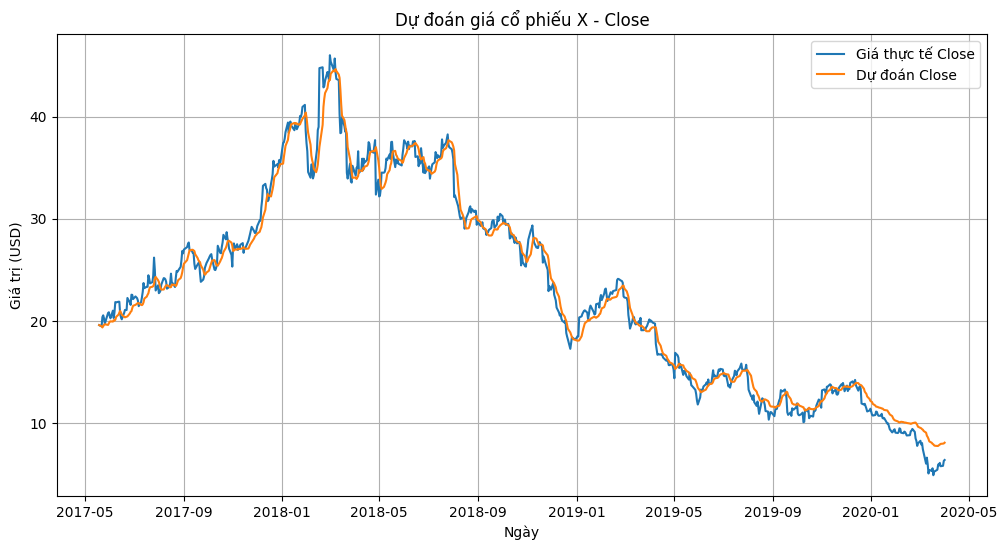

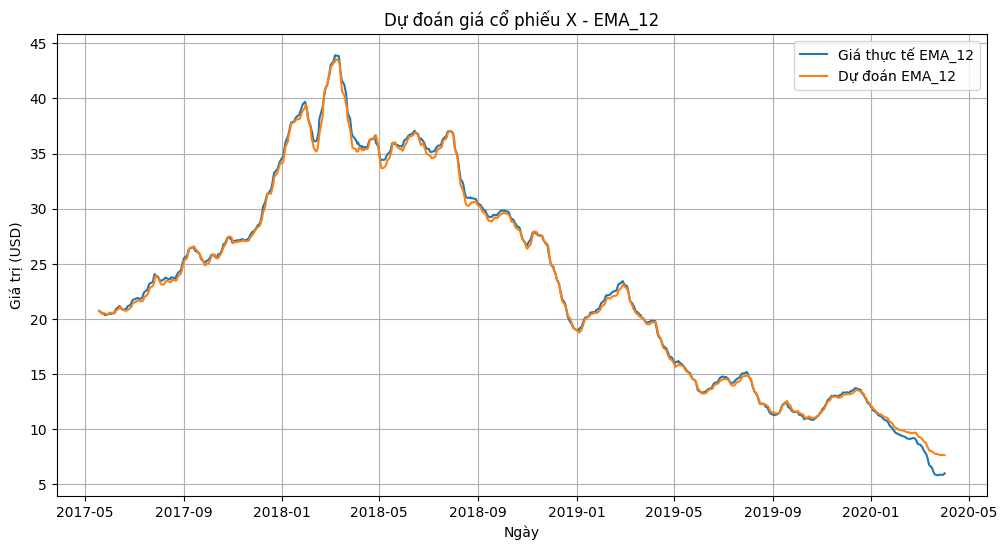

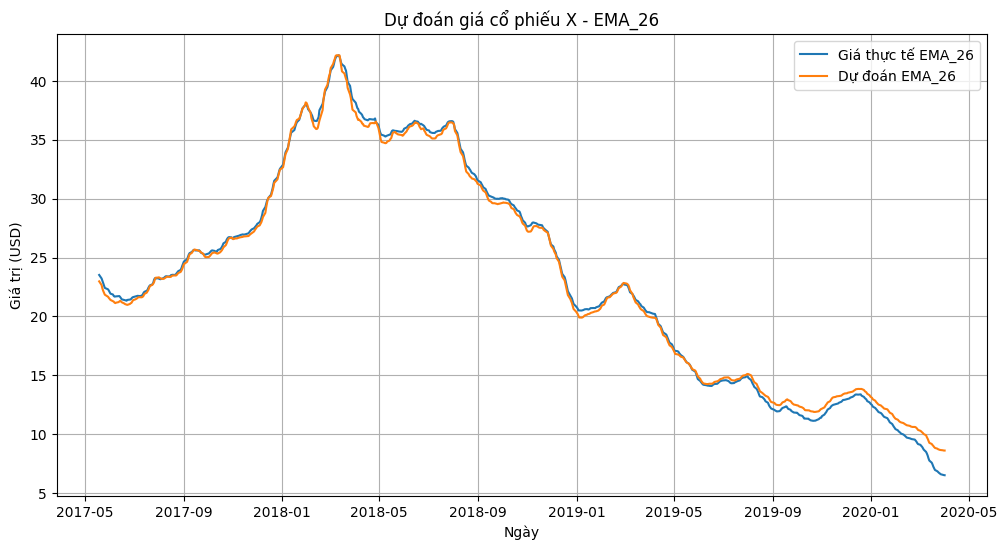


Xử lý mã cổ phiếu: KO
Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_22384\1116249066.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0155 - mae: 0.0644 - val_loss: 0.0010 - val_mae: 0.0289
Epoch 2/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 6.0845e-04 - mae: 0.0124 - val_loss: 0.0017 - val_mae: 0.0378
Epoch 3/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.3257e-04 - mae: 0.0106 - val_loss: 0.0026 - val_mae: 0.0484
Epoch 4/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.3086e-04 - mae: 0.0093 - val_loss: 0.0016 - val_mae: 0.0377
Epoch 5/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 2.7755e-04 - mae: 0.0086 - val_loss: 0.0025 - val_mae: 0.0481
Epoch 6/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 2.5251e-04 - mae: 0.0085 - val_loss: 0.0034 - val_mae: 0.0563
Epoch 7/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 2.1418e-04 - mae: 0.0079 - val_loss: 0.0031 - val_mae: 0.0537
Epoch 8/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.8509e-04 - mae: 0.0075 - val_loss: 0.0028 - val_mae: 0.0508
Epoch 9/200
365/365 ━━━━

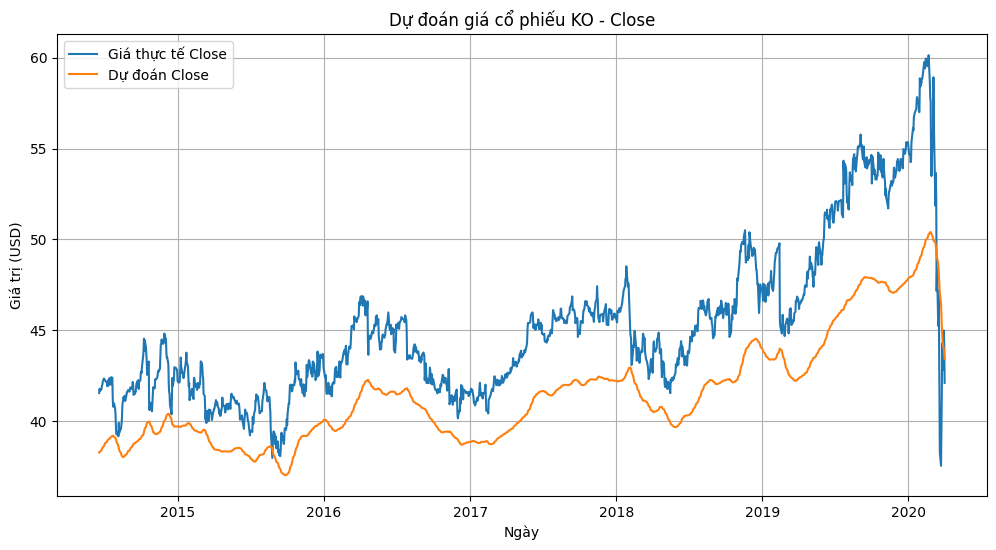

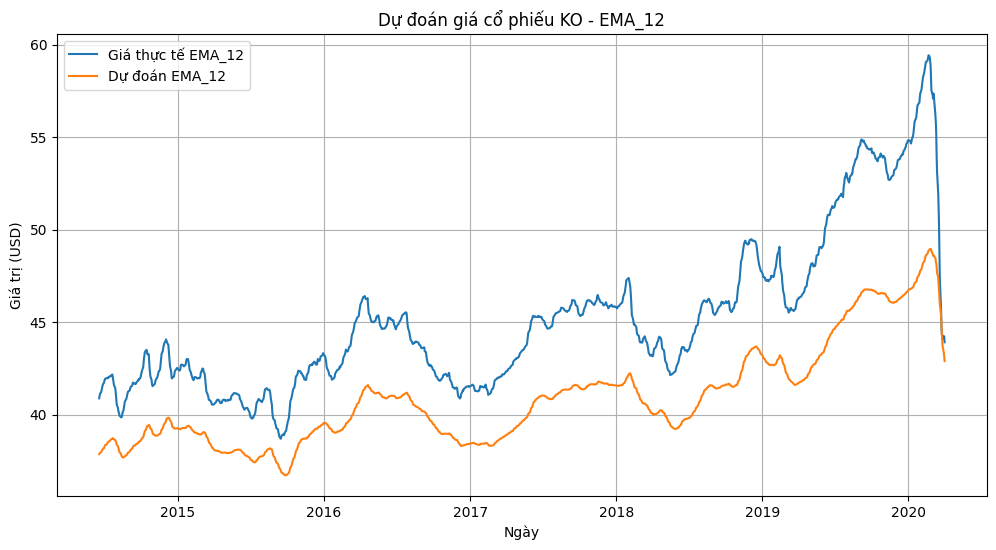

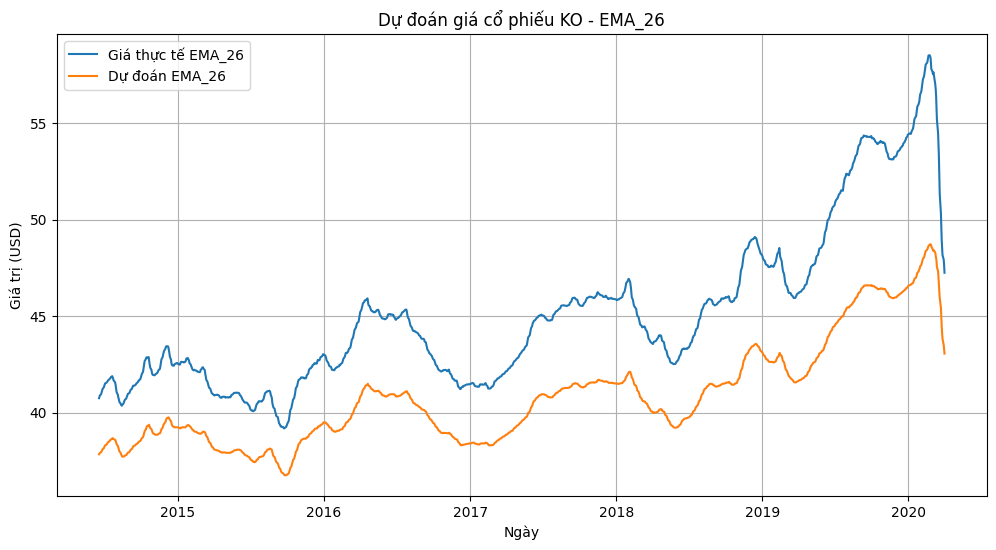


Xử lý mã cổ phiếu: INTL
Epoch 1/200


C:\Users\Admin\AppData\Local\Temp\ipykernel_22384\1116249066.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0410 - mae: 0.1422 - val_loss: 0.0032 - val_mae: 0.0477
Epoch 2/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0019 - mae: 0.0303 - val_loss: 0.0011 - val_mae: 0.0271
Epoch 3/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013 - mae: 0.0223 - val_loss: 0.0014 - val_mae: 0.0319
Epoch 4/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.7335e-04 - mae: 0.0191 - val_loss: 8.0339e-04 - val_mae: 0.0224
Epoch 5/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.1516e-04 - mae: 0.0177 - val_loss: 3.7773e-04 - val_mae: 0.0135
Epoch 6/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.7234e-04 - mae: 0.0169 - val_loss: 4.3330e-04 - val_mae: 0.0154
Epoch 7/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.9791e-04 - mae: 0.0162 - val_loss: 7.2920e-04 - val_mae: 0.0223
Epoch 8/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.3619e-04 - mae: 0.0155 - val_loss: 3.0999e-04 - val_mae: 0.0128
Epoch 9/200


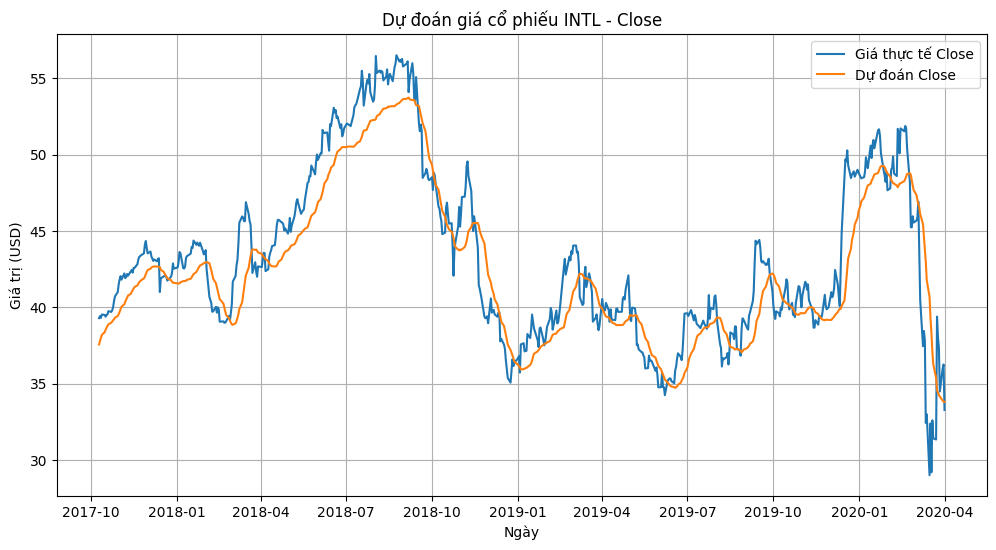

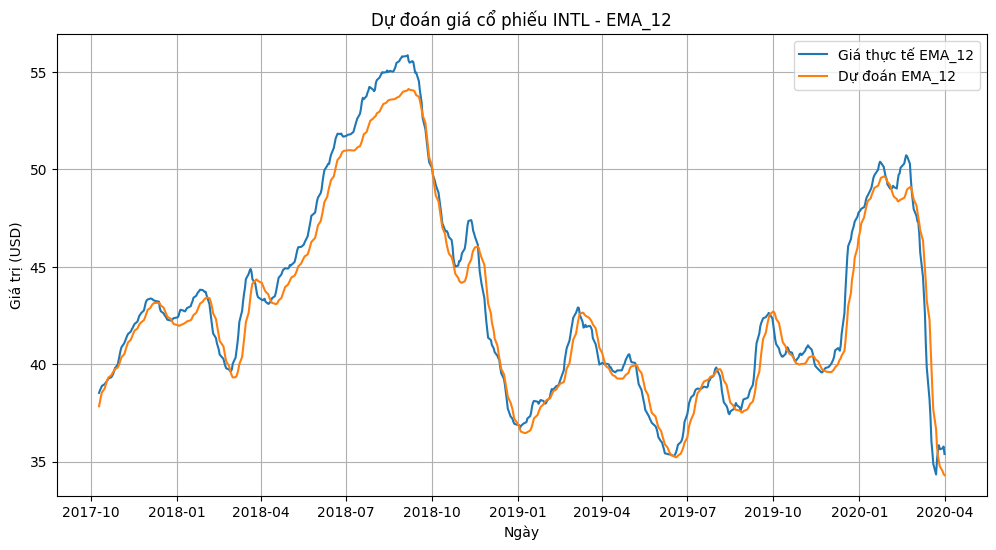

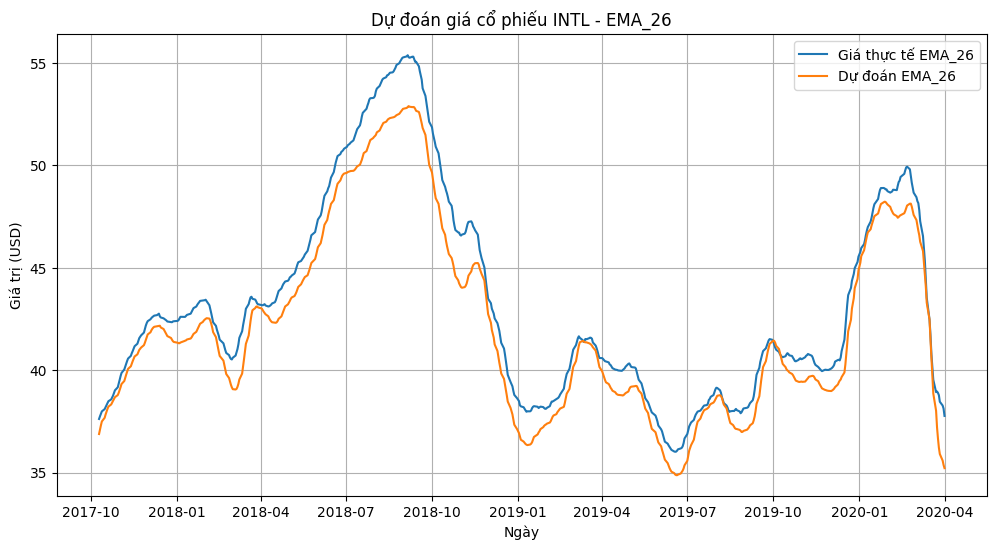

In [111]:
tickers = ['X', 'KO', 'INTL']
rmse_results = {}
for ticker in tickers:
    print(f"\nXử lý mã cổ phiếu: {ticker}")
    rmse, history = process_stock(ticker)
    rmse_results[ticker] = rmse

In [112]:
print("\nKết quả RMSE cho các mã cổ phiếu:")
for ticker, rmse in rmse_results.items():
    print(f"{ticker} - Close: {rmse[0]}")
    print(f"{ticker} - EMA_12: {rmse[1]}")
    print(f"{ticker} - EMA_26: {rmse[2]}")


Kết quả RMSE cho các mã cổ phiếu:
X - Close: 1.2029629903656474
X - EMA_12: 0.40683709668830875
X - EMA_26: 0.5139426576334803
KO - Close: 4.0541348912549156
KO - EMA_12: 4.552242369680744
KO - EMA_26: 4.517322631663731
INTL - Close: 2.3408783809779345
INTL - EMA_12: 1.0351284423847191
INTL - EMA_26: 1.300093505984779
